# Loan Delinquent Analysis

### Context

DRS bank is facing challenging times. Their NPAs (Non-Performing Assets) have been on a rise recently and a large part of these are due to the loans given to individual customers(borrowers). The Chief Risk Officer of the bank decides to put in a scientifically robust framework for approval of loans to individual customers to minimize the risk of loans converting into NPAs and initiates a project for the data science team at the bank. You, as a senior member of the team, are assigned this project.

### Objective
To identify the criteria to approve loans for an individual customer such that the likelihood of the loan delinquency is minimized

### Key questions to be answered
What are the factors that drive the behavior of loan delinquency?

### Data Description
* ID: Customer ID
* isDelinquent : indicates whether the customer is delinquent or not (1 => Yes, 0 => No)
* term: Loan term in months
* gender: Gender of the borrower
* age: Age of the borrower
* purpose: Purpose of Loan
* home_ownership: Status of borrower's home
* FICO: FICO (i.e. the bureau score) of the borrower

### Domain Information 
Transactor – A person who pays his due amount balance full and on time.

Revolver – A person who pays the minimum due amount but keeps revolving his balance and does not pay the full amount.

Delinquent - Delinquency means that you are behind on payments, a person who fails to pay even the minimum due amount.

Defaulter – Once you are delinquent for a certain period your lender will declare you to be in the default stage.

Risk Analytics – A wide domain in the financial and banking industry, basically analyzing the risk of the customer.


## Importing Libraries

In [1]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Data management libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libraries for statistical works
import scipy.stats as stats

# Classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, make_scorer)
from sklearn.model_selection import (GridSearchCV, train_test_split, KFold,
                                     StratifiedKFold, cross_val_score)
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks 

# Setting the theme and fontsize of figures
sns.set_theme(style = 'darkgrid', font_scale = 1.13)

# Restricting the float value of a dataframe to 3 decimal points
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Removing the limit for the number of displayed columns in a dataframe
pd.set_option("display.max_columns", None)

# Mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Loading Data

In [2]:
data_orig = pd.read_csv('/content/drive/MyDrive/Python_files/Loan_Delinquent_Dataset.csv')
# ensuring the original data remains untouched
df = data_orig.copy()

## Data Overview

### Data Shape

In [3]:
print('The dataset has {} columns and {} rows.'.format(df.shape[1], df.shape[0]))

The dataset has 8 columns and 11548 rows.


### Checking Head and Tail

In [4]:
df.head(7)

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
0,1,1,36 months,Female,House,Mortgage,>25,300-500
1,2,0,36 months,Female,House,Rent,20-25,>500
2,3,1,36 months,Female,House,Rent,>25,300-500
3,4,1,36 months,Female,Car,Mortgage,>25,300-500
4,5,1,36 months,Female,House,Rent,>25,300-500
5,6,1,36 months,Male,Car,Own,>25,>500
6,7,0,36 months,Female,House,Rent,>25,>500


In [5]:
df.tail(7)

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
11541,11542,1,36 months,Female,Wedding,Rent,>25,300-500
11542,11543,1,36 months,Male,House,Mortgage,>25,>500
11543,11544,0,60 months,Male,other,Mortgage,>25,300-500
11544,11545,1,36 months,Male,House,Rent,20-25,300-500
11545,11546,0,36 months,Female,Personal,Mortgage,20-25,>500
11546,11547,1,36 months,Female,House,Rent,20-25,300-500
11547,11548,1,36 months,Male,Personal,Mortgage,20-25,300-500


### General Information on Features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11548 non-null  int64 
 1   isDelinquent    11548 non-null  int64 
 2   term            11548 non-null  object
 3   gender          11548 non-null  object
 4   purpose         11548 non-null  object
 5   home_ownership  11548 non-null  object
 6   age             11548 non-null  object
 7   FICO            11548 non-null  object
dtypes: int64(2), object(6)
memory usage: 721.9+ KB


### Checking for Missing Values and Duplicates

In [7]:
print('The dataset has {} missing values and {} duplicated rows.'
                .format(df.isnull().sum().sum(), df.duplicated().sum()))

The dataset has 0 missing values and 0 duplicated rows.


### Minor Fixes


In [8]:
# Dropping unhelpful columns
print('No. of unique IDs:', df.ID.nunique())
df.drop(columns = 'ID', axis = 1, inplace = True)

No. of unique IDs: 11548


In [9]:
# Converting object-type cols into categories
for col in df.select_dtypes(include = 'object').columns.tolist():
    df[col] = pd.Categorical(df[col])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   isDelinquent    11548 non-null  int64   
 1   term            11548 non-null  category
 2   gender          11548 non-null  category
 3   purpose         11548 non-null  category
 4   home_ownership  11548 non-null  category
 5   age             11548 non-null  category
 6   FICO            11548 non-null  category
dtypes: category(6), int64(1)
memory usage: 159.0 KB


#### Notes:

Object-to-category conversion saved lots of space.

In [10]:
# Printing the share of all unique values of different features
for i, col in enumerate(df.select_dtypes(include = ['category', 'int']).columns.tolist()):
    if i < len(df.select_dtypes(include = ['category', 'int']).columns.tolist())-1:
      print(str(df[col].value_counts(1)) + '\n', end = '*'*45 + '\n')
    else:
      print(str(df[col].value_counts(1)))

1   0.669
0   0.331
Name: isDelinquent, dtype: float64
*********************************************
36 months   0.917
60 months   0.083
Name: term, dtype: float64
*********************************************
Male     0.568
Female   0.432
Name: gender, dtype: float64
*********************************************
House      0.597
Car        0.180
Other      0.080
Personal   0.077
Wedding    0.035
Medical    0.023
other      0.007
Name: purpose, dtype: float64
*********************************************
Mortgage   0.473
Rent       0.452
Own        0.075
Name: home_ownership, dtype: float64
*********************************************
20-25   0.510
>25     0.490
Name: age, dtype: float64
*********************************************
300-500   0.552
>500      0.448
Name: FICO, dtype: float64


#### Notes:

The two other ('other' and 'Other') classes in purpose column should certainly be merged.

In [11]:
# Merging 'other' with 'Other' for purpose
df['purpose'] = df['purpose'].replace('other', 'Other') 
df['purpose'].value_counts(1) 

House      0.597
Car        0.180
Other      0.087
Personal   0.077
Wedding    0.035
Medical    0.023
Name: purpose, dtype: float64

In [12]:
# Creating a categorical delinquency status column
df['delinquency_status'] = df['isDelinquent'].replace([0, 1], ['Non-Delinquent', 'Delinquent'])
df['delinquency_status'] = pd.Categorical(df['delinquency_status'])
df.head(3)

,isDelinquent,term,gender,purpose,home_ownership,age,FICO,delinquency_status
0,1,36 months,Female,House,Mortgage,>25,300-500,Delinquent
1,0,36 months,Female,House,Rent,20-25,>500,Non-Delinquent
2,1,36 months,Female,House,Rent,>25,300-500,Delinquent


### Staristical Summary

In [13]:
cat_stats = df.describe(include = 'category').T
cat_stats['frac'] = cat_stats['freq']/cat_stats['count']
cat_stats

,count,unique,top,freq,frac
term,11548,2,36 months,10589,0.917
gender,11548,2,Male,6555,0.568
purpose,11548,6,House,6892,0.597
home_ownership,11548,3,Mortgage,5461,0.473
age,11548,2,20-25,5888,0.510
FICO,11548,2,300-500,6370,0.552
delinquency_status,11548,2,Delinquent,7721,0.669


#### Observations:

*   None of the columns has any missing values, so data imputation-caused data leakage isn't a concern.
*   Most clients are male and between 20 and 25 years old, with quite low FICO scores (300-500). 
*   Shorter loans are more attractive.
*   The main purpose for taking a loan is buying a house, so unsurprisingly the most popularity of the clients are mortgage holders.
*  More than 2/3 of customers are delinquent!  



## EDA

In [14]:
# Auxiliary function for annotating the bars in a countplot
def countplot_labeling(cntplt, data, perc = True, decimal = 1):
  ''' This function gets a countplot and the dataset that has generated
  the plot to produce the values corresponding to each bar (category).
  If perc = True, percentages will be shown.'''

  from math import isnan

  total = data.shape[0]  # total number of values in the dataset
  for p in cntplt.patches:
        height_val = float(p.get_height())
        if(isnan(height_val)):
          height_val = 0
        if(abs(height_val - round(height_val)) < 1e-6):
          height_val = int(height_val)  
        if perc == True:
          # percentage of each category
          label = "{:.1f}%".format(100*height_val/total)
        else:
          label = "{}".format(round(height_val,decimal))  # count of each category
        x = p.get_x() + p.get_width()/2  # width of the plot
        y = p.get_height()  # height of the plot

        if(height_val == 0):
          label = '0'

        # annotate the bar
        cntplt.annotate(label, (x, y), ha = "center", va = "center", size = 12, xytext = (0, 5), textcoords = "offset points") 

### Univariate Analysis

**`Delinquency Status`**

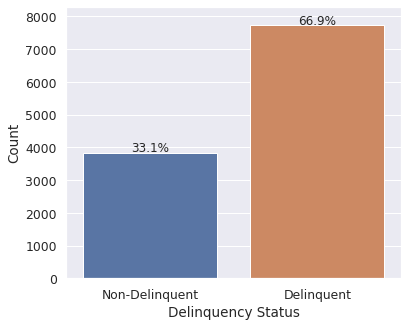

In [15]:
plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'delinquency_status', order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df);
plt.xlabel('Delinquency Status');
plt.ylabel('Count');
plt.ylim(0, 8300);

**`Loan Term`**

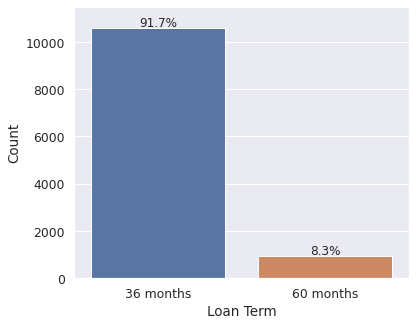

In [16]:
plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'term');
countplot_labeling(cntplt, df);
plt.xlabel('Loan Term');
plt.ylabel('Count');
plt.ylim(0, 11500);

**`Gender`**

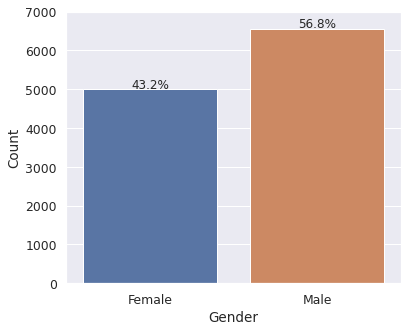

In [17]:
plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'gender');
countplot_labeling(cntplt, df);
plt.xlabel('Gender');
plt.ylabel('Count');
plt.ylim(0, 7000);

**`Loan Purpose`**

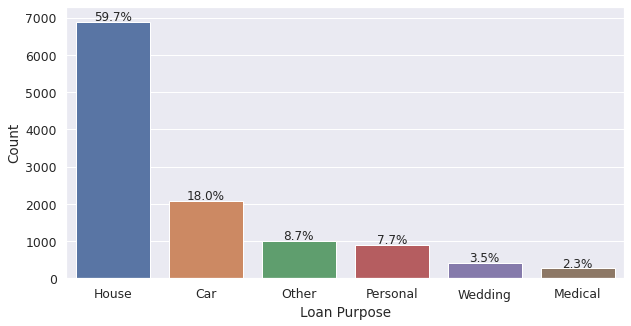

In [18]:
plt.figure(figsize = (10, 5));
cntplt = sns.countplot(data = df, x = 'purpose', 
                       order = df.purpose.value_counts(ascending = False).index.tolist());
countplot_labeling(cntplt, df);
plt.xlabel('Loan Purpose');
plt.ylabel('Count');
plt.ylim(0, 7300);

**`Home Ownership Status`**

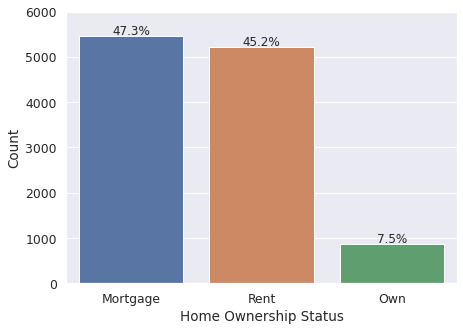

In [19]:
plt.figure(figsize = (7, 5));
cntplt = sns.countplot(data = df, x = 'home_ownership', 
                       order = df.home_ownership.value_counts(ascending = False).index.tolist());
countplot_labeling(cntplt, df);
plt.xlabel('Home Ownership Status');
plt.ylabel('Count');
plt.ylim(0, 6000);

**`Age Range`**

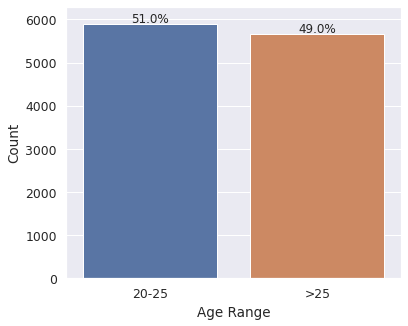

In [20]:
plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'age');
countplot_labeling(cntplt, df);
plt.xlabel('Age Range');
plt.ylabel('Count');
plt.ylim(0, 6300);

**`FICO Range`**

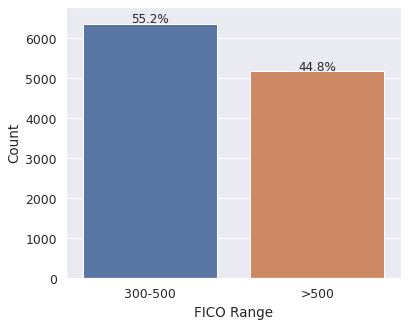

In [21]:
plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'FICO');
countplot_labeling(cntplt, df);
plt.xlabel('FICO Range');
plt.ylabel('Count');
plt.ylim(0, 6800);

#### Observations:

*   66.9% of clients in the dataset are ***delinquent***.
*   91.7% of clients take ***shorter-term*** loans whose period is 36 months, as opposed to taking out longer-term loans whose with the payback length of 60 months.
*   The majority (59.7%) of the clients take out loans tfor the ***purpose*** of purchasing homes, while buying cars ranks as the second most frequent purpose with 18%. Only 2.3% of the clients take out medical loans, making it the least prevalent reason of becoming a borrower.
*   56.8% of clients are ***male***.
*   Only 7.5% of the clients full own their places of residence. 45.2% are renters and the remainders are mortgage holders. 
*   The ***age*** 51% of the clients fall in the range of 20 to 25.
*   Only 44.8% of the clients have a ***FICO score*** above 500.



### Bivariate Analysis

**`Delinquency Status vs. Loan Term`**

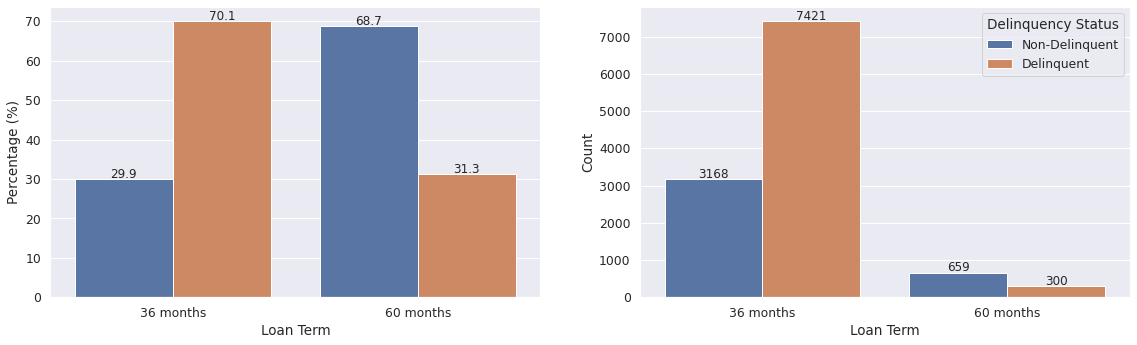

In [22]:
# Generating a crosstab of loan term and delinquency status
ctab = pd.crosstab(df['term'], df['delinquency_status'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of loan term w.r.t. delinquency status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'term', y = 'value', hue = 'delinquency_status', 
                     hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Loan Term');
plt.ylabel('Percentage (%)');
plt.legend(title = 'Delinquency Status').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'term', hue = 'delinquency_status', 
                       hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Loan Term');
plt.ylabel('Count');
plt.legend(title = 'Delinquency Status');
plt.tight_layout(w_pad = 3);

#### Observations:

Those borrowing shorter-term loans are much likelier to become delinquent.

**`Delinquency Status vs. Gender`**

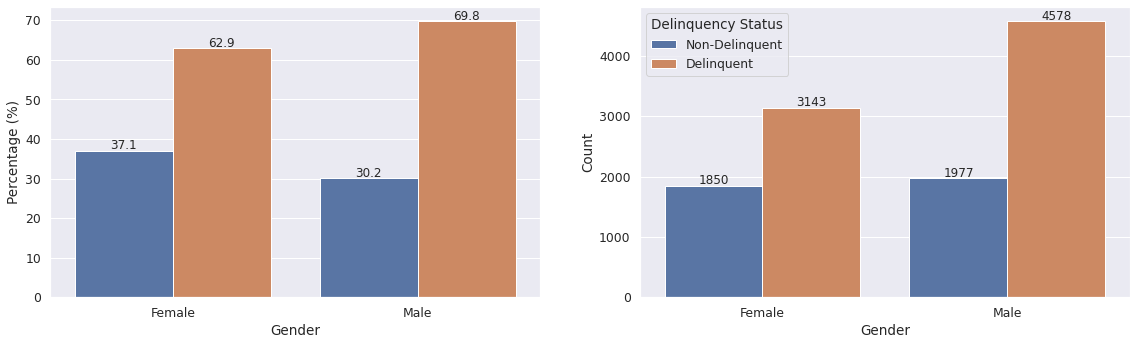

In [23]:
# Generating a crosstab of gender and delinquency status
ctab = pd.crosstab(df['gender'], df['delinquency_status'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of gender w.r.t. delinquency status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'gender', y = 'value', hue = 'delinquency_status', 
                     hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Gender');
plt.ylabel('Percentage (%)');
plt.legend(title = 'Delinquency Status').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'gender', hue = 'delinquency_status', 
                       hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Gender');
plt.ylabel('Count');
plt.legend(title = 'Delinquency Status');
plt.tight_layout(w_pad = 3);

#### Observations:

While there is no significant difference between the delinquency status of men and women, men are slightly more likely to fall behind the repayment of their loans.

**`Delinquency Status vs. Loan Purpose`**

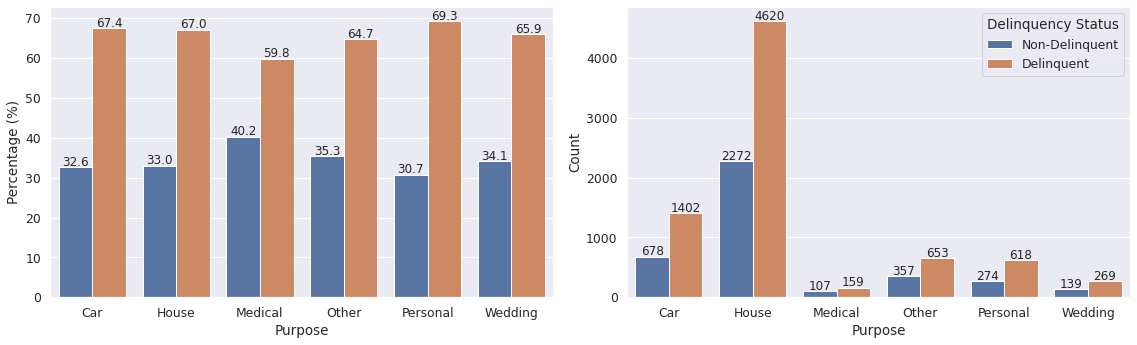

In [24]:
# Generating a crosstab of loan purpose and delinquency status
ctab = pd.crosstab(df['purpose'], df['delinquency_status'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of purpose w.r.t. delinquency status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'purpose', y = 'value', hue = 'delinquency_status', 
                     hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Purpose');
plt.ylabel('Percentage (%)');
plt.legend(title = 'Delinquency Status').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'purpose', hue = 'delinquency_status', 
                       hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Purpose');
plt.ylabel('Count');
plt.legend(title = 'Delinquency Status');
plt.tight_layout();

#### Observations:

Medical loans have a slightly lower rate of delinquency, but overall, the delinquency status and rate are barely impacted by the loan purpose. 

**`Delinquency Status vs. Home Ownership Status`**

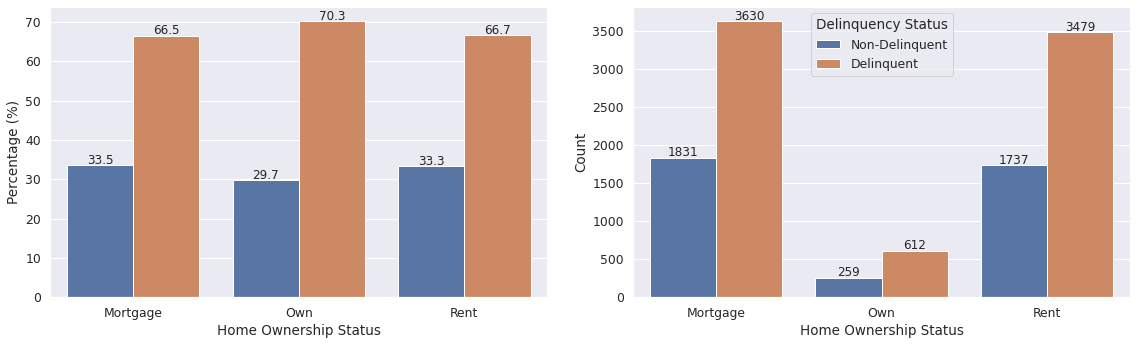

In [25]:
# Generating a crosstab of home ownership status and delinquency status
ctab = pd.crosstab(df['home_ownership'], df['delinquency_status'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of home ownership status w.r.t. delinquency status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'home_ownership', y = 'value', hue = 'delinquency_status', 
                     hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Home Ownership Status');
plt.ylabel('Percentage (%)');
plt.legend(title = 'Delinquency Status').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'home_ownership', hue = 'delinquency_status', 
                       hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Home Ownership Status');
plt.ylabel('Count');
plt.legend(title = 'Delinquency Status');
plt.tight_layout(w_pad = 2);

#### Observations:

Home ownership status has almost no effect on the delinquency status.

**`Delinquency Status vs. Age`**

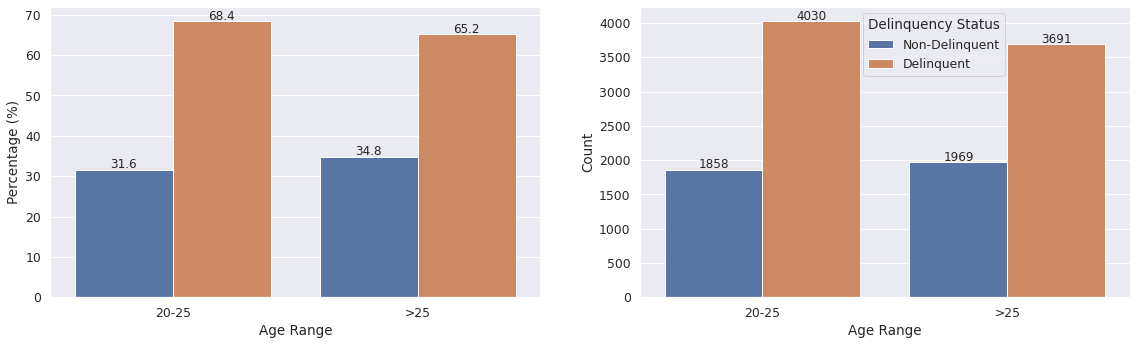

In [26]:
# Generating a crosstab of age range and delinquency status
ctab = pd.crosstab(df['age'], df['delinquency_status'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of age range w.r.t. delinquency status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'age', y = 'value', hue = 'delinquency_status', 
                     hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Age Range');
plt.ylabel('Percentage (%)');
plt.legend(title = 'Delinquency Status').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'age', hue = 'delinquency_status', 
                       hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Age Range');
plt.ylabel('Count');
plt.legend(title = 'Delinquency Status', loc = 'upper center', bbox_to_anchor = [0.6, 1]);
plt.tight_layout(w_pad = 3);

#### Observations:

Older clients have a slightly lower rate of delinquency, but nonetheless, age doesn't appear to be a decisive factor for loan repayment. 

**`Delinquency Status vs. FICO Score`**

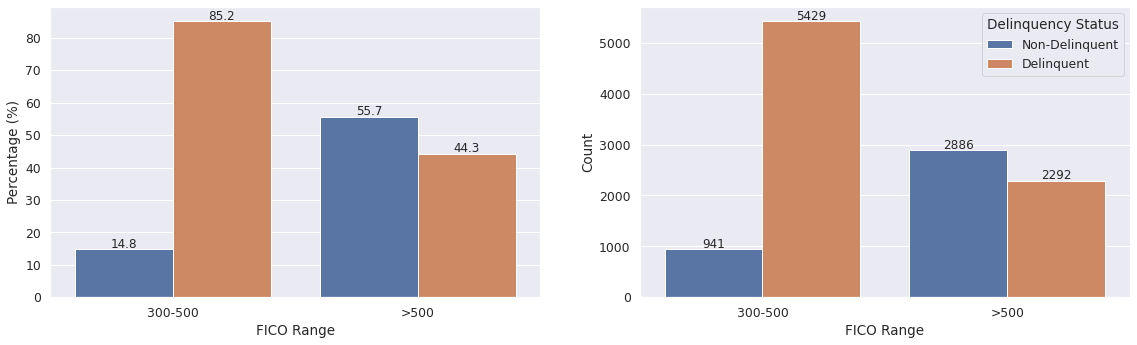

In [27]:
# Generating a crosstab of FICO score and delinquency status
ctab = pd.crosstab(df['FICO'], df['delinquency_status'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of FICO score w.r.t. delinquency status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'FICO', y = 'value', hue = 'delinquency_status', 
                     hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('FICO Range');
plt.ylabel('Percentage (%)');
plt.legend(title = 'Delinquency Status').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'FICO', hue = 'delinquency_status', 
                       hue_order = ['Non-Delinquent', 'Delinquent']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('FICO Range');
plt.ylabel('Count');
plt.legend(title = 'Delinquency Status');
plt.tight_layout(w_pad = 3);

#### Observations:

Along with loan term, the FICO score turn out to be a very crucial predictor of delinquency status.

**`FICO Score vs. Gender`**

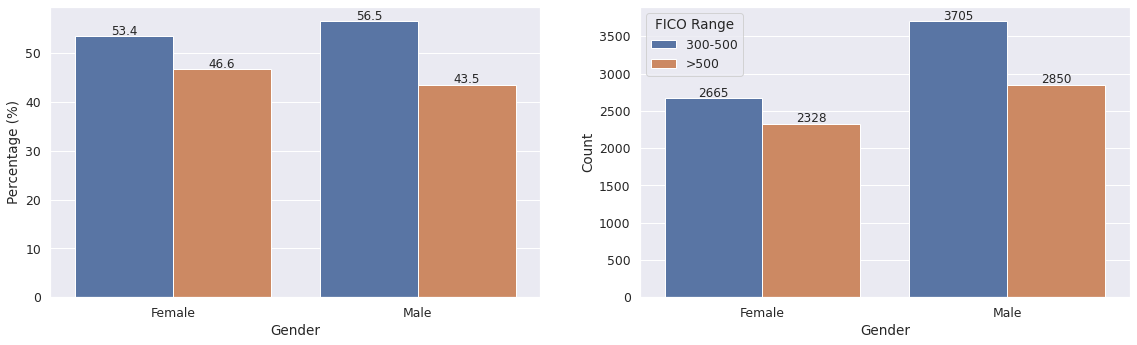

In [28]:
# Generating a crosstab of gender and FICO score
ctab = pd.crosstab(df['gender'], df['FICO'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of FICO score w.r.t. gender    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'gender', y = 'value', hue = 'FICO');
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Gender');
plt.ylabel('Percentage (%)');
plt.legend(title = 'FICO Range').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'gender', hue = 'FICO');
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Gender');
plt.ylabel('Count');
plt.legend(title = 'FICO Range', loc = 'upper left');
plt.tight_layout(w_pad = 3);

#### Observations:

FICO scores of women are slightly higher, but gender barely influences the FICO score.

**`FICO Score vs. Home Ownership Status`**

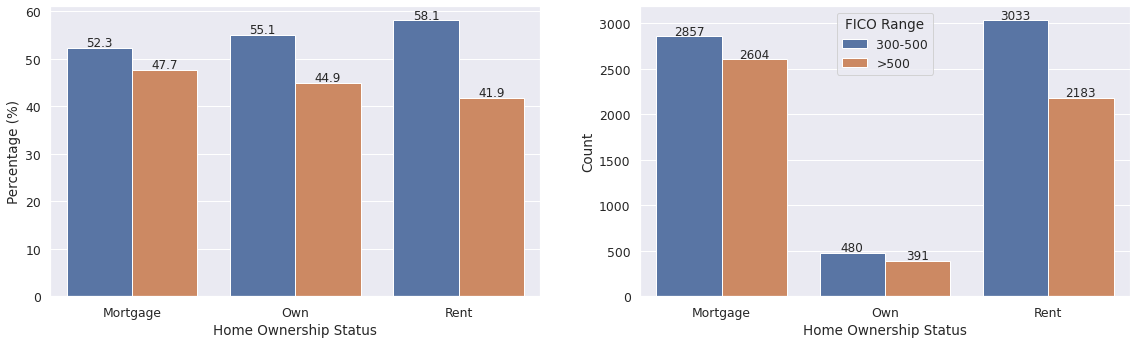

In [29]:
# Generating a crosstab of home ownership status and FICO score
ctab = pd.crosstab(df['home_ownership'], df['FICO'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of FICO score w.r.t. home ownership status    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'home_ownership', y = 'value', hue = 'FICO');
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Home Ownership Status');
plt.ylabel('Percentage (%)');
plt.legend(title = 'FICO Range').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'home_ownership', hue = 'FICO');
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Home Ownership Status');
plt.ylabel('Count');
plt.legend(title = 'FICO Range', loc = 'upper center');
plt.tight_layout(w_pad = 3);

#### Observations:

The mortgate holders have slightly higher FICO scores than the two other groups, and the renters have the lowest FICO scores, but the variation of FICO score with the home ownership status is fairly minor.

**`FICO Score vs. Age`**

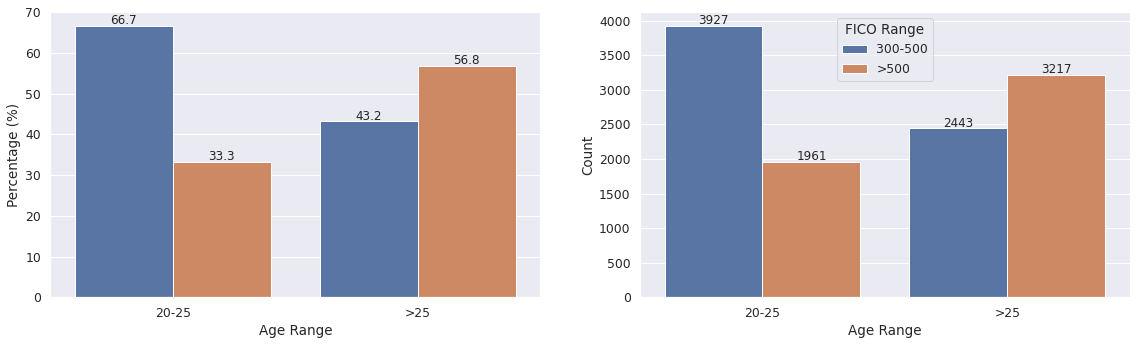

In [30]:
# Generating a crosstab of age range and FICO score
ctab = pd.crosstab(df['age'], df['FICO'], normalize = 'index')
# Converting the crosstab into a dataframe
ctab_df = ctab.stack().reset_index()
# Turning fractions into percentages
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df['value'] = ctab_df['value']*100

# The count/barplot of FICO score w.r.t. age range    
plt.figure(figsize = (16, 5));
# Percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab_df, x = 'age', y = 'value', hue = 'FICO');
countplot_labeling(barplt, ctab_df, perc = False);
plt.xlabel('Age Range');
plt.ylabel('Percentage (%)');
plt.legend(title = 'FICO Range').set_visible(False);
# Value count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'age', hue = 'FICO');
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Age Range');
plt.ylabel('Count');
plt.legend(title = 'FICO Range', loc = 'upper center');
plt.tight_layout(w_pad = 3);

#### Observations:

Unsurprisingly, older clients have much higher credit scores than the younger ones. One major contributor to this fact is certainly their longer credit histories. 

### Hypothesis Testing

We run Chi-square test of independence to demonstrate the strong relationship between the FICO score and delinquency status, and to determine the possible dependency of FICO score on gender, home ownership status and age. The significane level of all these tests are set at 5%.

$H_0$: There is not enough statistical evidence to assert that the two categorical variables under study are associated.

$H_a$: With enough statistical, it can be asserted that the the two categorical variables under study are associated.

**`FICO Score & Delinquency Status`**

In [31]:
# Making a crosstab of FICO score and delinquency status 
ctab = pd.crosstab(df['FICO'], df['delinquency_status'])
# Conducting the hypothesis testing
chi2, pval, expected, dof = stats.chi2_contingency(ctab)

# Prining the outcome of the statistical test
print('p-value =', round(pval, 100))
if pval < 0.05:
    print('There is a statsitically significant relationship between the FICO score and delinquency status.')
else:
    print('There is NO statsitically significant relationship between the FICO score and delinquency status.')

p-value = 0.0
There is a statsitically significant relationship between the FICO score and delinquency status.


**`Gender & FICO Score`**

In [32]:
# Making a crosstab of gender and FICO score 
ctab = pd.crosstab(df['gender'], df['FICO'])
# Conducting the hypothesis testing
chi2, pval, expected, dof = stats.chi2_contingency(ctab)

# Prining the outcome of the statistical test
print('p-value =', round(pval, 6))
if pval < 0.05:
    print('There is a statsitically significant relationship between gender and the FICO score.')
else:
    print('There is NO statsitically significant relationship between gender and the FICO score.')

p-value = 0.000809
There is a statsitically significant relationship between gender and the FICO score.


**`Home Ownership Status & FICO Score`**

In [33]:
# Making a crosstab of home ownership status and FICO score 
ctab = pd.crosstab(df['home_ownership'], df['FICO'])
# Conducting the hypothesis testing
chi2, pval, expected, dof = stats.chi2_contingency(ctab)

# Prining the outcome of the statistical test
print('p-value =', round(pval, 11))
if pval < 0.05:
    print('There is a statsitically significant relationship between home ownership status and the FICO score.')
else:
    print('There is NO statsitically significant relationship between home ownership status and the FICO score.')

p-value = 1.083e-08
There is a statsitically significant relationship between home ownership status and the FICO score.


**`Age & FICO Score`**

In [34]:
# Making a crosstab of age and FICO score 
ctab = pd.crosstab(df['age'], df['FICO'])
# Conducting the hypothesis testing
chi2, pval, expected, dof = stats.chi2_contingency(ctab)

# Prining the outcome of the statistical test
print('p-value =', round(pval, 100))
if pval < 0.05:
    print('There is a statsitically significant relationship between age and the FICO score.')
else:
    print('There is NO statsitically significant relationship between age and the FICO score.')

p-value = 0.0
There is a statsitically significant relationship between age and the FICO score.


#### Observations:


*   As established by the EDA-based analysis, the FICO score and delinquency status are very strongly related. The FICO score also largely depend on the age of clients.
*   However the bivariate analysis demonstrated that the FICO score is barely influenced by age and gender, hypothesis testings conducted above indicate that, with more than 95% confidence, the FICO score should be viewed associated with gender and age. 



## Building the Classification Models


*   Here, ***Logistic Regression*** is chosen for ML-based classification, which easily allows for regularization.
*   The ***recall score*** is selected as the evaluation metric, since identifying all delinquent clients is far more important than discerning the non-delinqeunt ones. Minimizing FNs, which is what a high recall score accomplishes, is vastly important in this problem, because the damage of giving loans to delinquent clients is much greater than the opportunity loss of mislabeling transactors (or revolvers) as delinquents. 



In [35]:
# Auxiliary function for plotting confusion matrices of classification models
def confusion_matrix_evince(y_truth, y_pred):
    '''This function generates a 2*2 heatmap representing the confusion matrix of
    actual data and predictions.'''

    # Evaluating the confusion matrix
    cm = confusion_matrix(y_truth, y_pred)
    # Converting the confusion matrix into a dataframe
    cm_df = pd.DataFrame(cm, index = ['Truth - Non-Delinquent', 'Truth - Delinquent'], 
                         columns = ['Prediction - Non-Delinquent', 'Prediction - Delinquent'])
    
    # Generating the labels of the confusion matrix heatmap
    labels = []
    for i in range(len(cm.flatten())):
        labels.append(str(cm.flatten()[i]) + '\n(' + str(round(cm.flatten()[i]/cm.flatten().sum()*100, 2)) + '%)')
    labels = np.asarray(labels).reshape(2, 2)
    
    # Demonstrating the confusion matrix in the form of a heatmap
    sns.heatmap(cm_df, fmt = '', annot = labels, vmin = -len(y_truth), vmax = len(y_truth),
                cbar = False, cmap = 'seismic');
    plt.xlabel('Prediction');
    plt.ylabel('Truth');

In [36]:
# Auxiliary function for reporting the performance metrics on training and testing (validation) data
def model_eval(model, X_train, X_valid, y_train, y_valid, valid = True):
    '''This function calculates the performance metrics of a given classification model
    on training and validation (testing) data, and returns them in the form of a dataframe.
    Set valid = False, if a testing set, instead of a validation set, has been passed to
    the function.'''
    
    # Reconstructing the training set
    y_recon = model.predict(X_train)
    # Making predictions for validation (testing) set
    y_pred = model.predict(X_valid)

    # Building a dataframe of evaluation metrics
    model_perform = pd.DataFrame(index = ['Train', 'Test'], columns = ['Accuracy', 'Recall', 'Precision', 'F1', 'Specificity'])
    if(valid):
        model_perform.index = ['Train', 'Validation']

    # Calculating the model performance on training set
    model_perform.iloc[0, :] = [accuracy_score(y_train, y_recon), recall_score(y_train, y_recon),
                                precision_score(y_train, y_recon), f1_score(y_train, y_recon), 
                                recall_score(y_train, y_recon, pos_label = 0)]
    # Calculating the model performance on testing set
    model_perform.iloc[1, :] = [accuracy_score(y_valid, y_pred), recall_score(y_valid, y_pred),
                                precision_score(y_valid, y_pred), f1_score(y_valid, y_pred), 
                                recall_score(y_valid, y_pred, pos_label = 0)]

    return model_perform 

### Data Preparation

In [37]:
# Dropping the categorical delinquency status columns
df_model = df.drop(columns = 'delinquency_status', axis = 1)
# Renaming the isDelinquent column
df_model.rename(columns = {'isDelinquent': 'delinquency_status'}, inplace = True)
df_model.head(3)

,delinquency_status,term,gender,purpose,home_ownership,age,FICO
0,1,36 months,Female,House,Mortgage,>25,300-500
1,0,36 months,Female,House,Rent,20-25,>500
2,1,36 months,Female,House,Rent,>25,300-500


In [38]:
# Separating data into predictors and target 
X = df_model.drop(columns = 'delinquency_status', axis = 1)
y = df_model['delinquency_status']
# Converting classes of categorical variables into dummy variables 
X = pd.get_dummies(X, columns = X.select_dtypes(include = 'category').columns.tolist(), drop_first = True)

# Building training, validation and testing sets
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, train_size = 0.7, stratify = y, random_state = 1)
X_valid, X_test, y_valid, y_test = train_test_split(X_not_train, y_not_train, test_size = 0.5, stratify = y_not_train, random_state = 1)
del X_not_train, y_not_train

# Printing no. of recors in each of training, validation and testing sets
print('No. of rows in training set =', X_train.shape[0])
print('No. of rows in validation set =', X_valid.shape[0])
print('No. of rows in testing set =', X_test.shape[0], end = '\n'*2)

# Checking the share of each class in training, validation and testing sets 
print('Fraction of different classes in the original data:\n', y.value_counts(1), 
      end = '\n' + 60*'*' + '\n', sep = '')
print('Fraction of different classes in the training set:\n', y_train.value_counts(1), 
      end = '\n' + 60*'*' + '\n', sep = '')
print('Fraction of different classes in the validation set:\n', y_valid.value_counts(1), 
      end = '\n' + 60*'*' + '\n', sep = '')
print('Fraction of different classes in the testing set:\n', y_test.value_counts(1), sep = '')

No. of rows in training set = 8083
No. of rows in validation set = 1732
No. of rows in testing set = 1733

Fraction of different classes in the original data:
1   0.669
0   0.331
Name: delinquency_status, dtype: float64
************************************************************
Fraction of different classes in the training set:
1   0.669
0   0.331
Name: delinquency_status, dtype: float64
************************************************************
Fraction of different classes in the validation set:
1   0.669
0   0.331
Name: delinquency_status, dtype: float64
************************************************************
Fraction of different classes in the testing set:
1   0.669
0   0.331
Name: delinquency_status, dtype: float64


### Baseline Model

In [39]:
# Building the baseline model (no regularization or over/undersampling)
lgc0 = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 1)
lgc0 = lgc0.fit(X_train, y_train)

In [40]:
# Demonstrating the performance of model on training and validation sets
lgc0_perform = model_eval(lgc0, X_train, X_valid, y_train, y_valid)
lgc0_perform

,Accuracy,Recall,Precision,F1,Specificity
Train,0.789,0.877,0.820,0.847,0.611
Validation,0.786,0.889,0.809,0.847,0.577


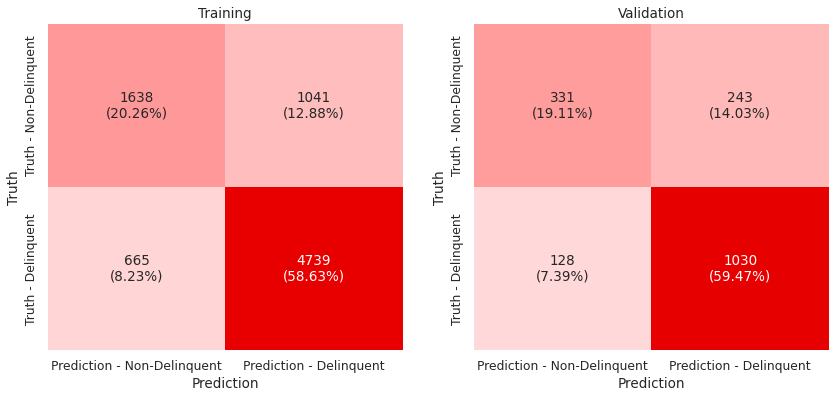

In [41]:
# Confusion matrices for training and validation sets
y_recon = lgc0.predict(X_train) # Reconstructing the training data
y_pred = lgc0.predict(X_valid)  # Forecasting the validation data

# Plotting the confusion matrices
plt.figure(figsize = (14, 6));
# Training data
plt.subplot(121);
confusion_matrix_evince(y_train, y_recon);
plt.title('Training');
# Validation data
plt.subplot(122);
confusion_matrix_evince(y_valid, y_pred);
plt.title('Validation');

In [42]:
# Cross-validation on training set to find out the range of performance 

# Dividing training set into 10 random folds
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
# Evaluating the recall score on all folds
cv_recalls = cross_val_score(lgc0, X_train, y_train, cv = kfold, scoring = 'recall')

print('The average recall score of the baseline model is {} and, with 95% confidence, the recall score falls between {} and {}.'
      .format(round(cv_recalls.mean(), 3), round(cv_recalls.mean() - 2*cv_recalls.std(), 3),
              round(cv_recalls.mean() + 2*cv_recalls.std(), 3)))   

The average recall score of the baseline model is 0.877 and, with 95% confidence, the recall score falls between 0.855 and 0.898.


### Oversampled Model

In [43]:
# Creating an oversampled data using SMOTE
oversampling_scheme = SMOTE(sampling_strategy = 'all', random_state = 1)
X_train_over, y_train_over = oversampling_scheme.fit_resample(X_train, y_train)

print('Count of delinquent class before resampling: {} ({}%)'
            .format(y_train.value_counts()[1], round(y_train.value_counts(1)[1]*100, 1)))
print('Count of non-delinquent class before resampling: {} ({}%)'
            .format(y_train.value_counts()[0], round(y_train.value_counts(1)[0]*100, 1)), end = '\n'*2)
print('Count of delinquent class after resampling: {} ({}%)'
            .format(y_train_over.value_counts()[1], round(y_train_over.value_counts(1)[1]*100, 1)))
print('Count of non-delinquent class after resampling: {} ({}%)'
            .format(y_train_over.value_counts()[0], round(y_train_over.value_counts(1)[0]*100, 1)), end = '\n'*2)
print('Size of training set before/after resampling: {}/{}'.format(X_train.shape[0], X_train_over.shape[0]))

Count of delinquent class before resampling: 5404 (66.9%)
Count of non-delinquent class before resampling: 2679 (33.1%)

Count of delinquent class after resampling: 5404 (50.0%)
Count of non-delinquent class after resampling: 5404 (50.0%)

Size of training set before/after resampling: 8083/10808


In [44]:
# Building the logistic regression model using the oversampled data
lgc_over = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 1)
lgc_over = lgc_over.fit(X_train_over, y_train_over)

In [45]:
# Demonstrating the performance of model on training and validation sets
lgc_over_perform = model_eval(lgc_over, X_train_over, X_valid, y_train_over, y_valid)
lgc_over_perform

,Accuracy,Recall,Precision,F1,Specificity
Train,0.775,0.698,0.825,0.756,0.852
Validation,0.748,0.707,0.894,0.790,0.831


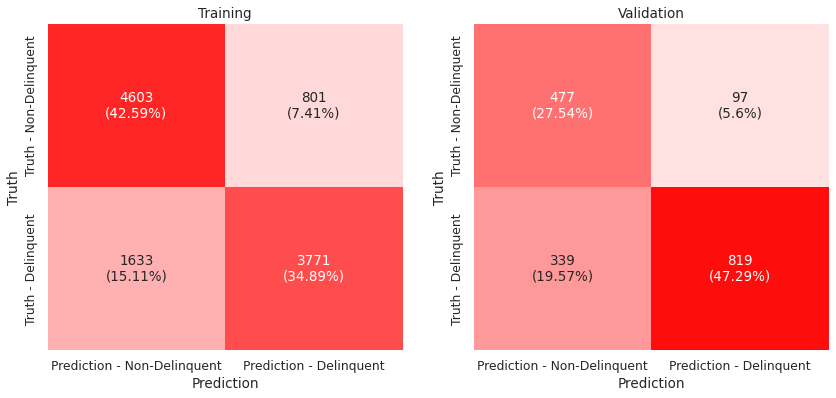

In [46]:
# Confusion matrices for training and validation sets
y_recon = lgc_over.predict(X_train_over) # Reconstructing the training data
y_pred = lgc_over.predict(X_valid)  # Forecasting the validation data

# Plotting the confusion matrices
plt.figure(figsize = (14, 6));
# Training data
plt.subplot(121);
confusion_matrix_evince(y_train_over, y_recon);
plt.title('Training');
# Validation data
plt.subplot(122);
confusion_matrix_evince(y_valid, y_pred);
plt.title('Validation');

In [47]:
# Cross-validation on training set to find out the range of performance 

# Dividing training set into 10 random folds
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
# Evaluating the recall score on all folds
cv_recalls = cross_val_score(lgc_over, X_train_over, y_train_over, cv = kfold, scoring = 'recall')

print('The average recall score of the oversampled model is {} and, with 95% confidence, the recall score falls between {} and {}.'
      .format(round(cv_recalls.mean(), 3), round(cv_recalls.mean() - 2*cv_recalls.std(), 3),
              round(cv_recalls.mean() + 2*cv_recalls.std(), 3)))   

The average recall score of the oversampled model is 0.698 and, with 95% confidence, the recall score falls between 0.66 and 0.735.


### Undersampled Model

In [48]:
# Creating an oversampled data using SMOTE
undersampling_scheme = RandomUnderSampler(sampling_strategy = 'all', random_state = 1)
X_train_under, y_train_under = undersampling_scheme.fit_resample(X_train, y_train)

print('Count of delinquent class before resampling: {} ({}%)'
            .format(y_train.value_counts()[1], round(y_train.value_counts(1)[1]*100, 1)))
print('Count of non-delinquent class before resampling: {} ({}%)'
            .format(y_train.value_counts()[0], round(y_train.value_counts(1)[0]*100, 1)), end = '\n'*2)
print('Count of delinquent class after resampling: {} ({}%)'
            .format(y_train_under.value_counts()[1], round(y_train_under.value_counts(1)[1]*100, 1)))
print('Count of non-delinquent class after resampling: {} ({}%)'
            .format(y_train_under.value_counts()[0], round(y_train_under.value_counts(1)[0]*100, 1)), end = '\n'*2)
print('Size of training set before/after resampling: {}/{}'.format(X_train.shape[0], X_train_under.shape[0]))

Count of delinquent class before resampling: 5404 (66.9%)
Count of non-delinquent class before resampling: 2679 (33.1%)

Count of delinquent class after resampling: 2679 (50.0%)
Count of non-delinquent class after resampling: 2679 (50.0%)

Size of training set before/after resampling: 8083/5358


In [49]:
# Building the logistic regression model using the undersampled data
lgc_under = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 1)
lgc_under = lgc_under.fit(X_train_under, y_train_under)

In [50]:
# Demonstrating the performance of model on training and validation sets
lgc_under_perform = model_eval(lgc_under, X_train_under, X_valid, y_train_under, y_valid)
lgc_under_perform

,Accuracy,Recall,Precision,F1,Specificity
Train,0.790,0.769,0.803,0.786,0.811
Validation,0.786,0.784,0.882,0.830,0.789


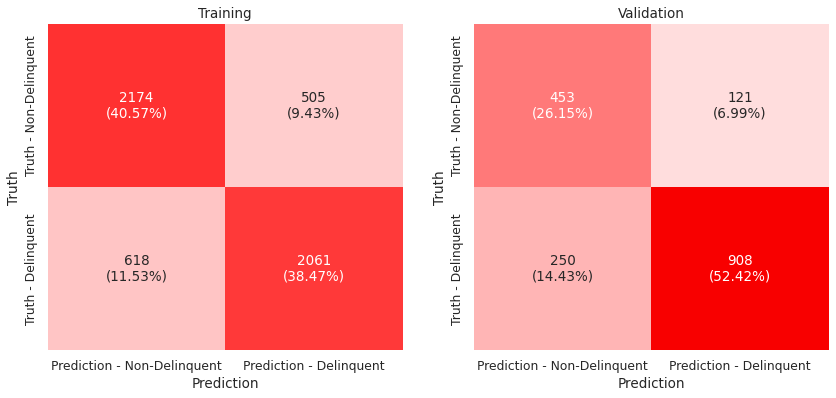

In [51]:
# Confusion matrices for training and validation sets
y_recon = lgc_under.predict(X_train_under) # Reconstructing the training data
y_pred = lgc_under.predict(X_valid)  # Forecasting the validation data

# Plotting the confusion matrices
plt.figure(figsize = (14, 6));
# Training data
plt.subplot(121);
confusion_matrix_evince(y_train_under, y_recon);
plt.title('Training');
# Validation data
plt.subplot(122);
confusion_matrix_evince(y_valid, y_pred);
plt.title('Validation');

In [52]:
# Cross-validation on training set to find out the range of performance 

# Dividing training set into 10 random folds
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
# Evaluating the recall score on all folds
cv_recalls = cross_val_score(lgc_under, X_train_under, y_train_under, cv = kfold, scoring = 'recall')

print('The average recall score of the oversampled model is {} and, with 95% confidence, the recall score falls between {} and {}.'
      .format(round(cv_recalls.mean(), 3), round(cv_recalls.mean() - 2*cv_recalls.std(), 3),
              round(cv_recalls.mean() + 2*cv_recalls.std(), 3)))   

The average recall score of the oversampled model is 0.764 and, with 95% confidence, the recall score falls between 0.71 and 0.819.


#### Observations:

*   Since, accurate capturing of the majority (delinquent) class here is the major objective, the imbalance of data is actually in our favor, and its removal reduces our performance measure of interest (recall).  
*   Oversampling hurt the results more than undersampling does, as it generates additional, unhelpful and unnecessary data (at least for the main goal of the problem).
*   Specificity is the only measure improved by resampling, as it corresponds to the correct identification of the 0 (non-delinquent) class.
*   As expected, resampling has led to some level of overfitting (at least in comparison with the baseline model), since it usually mixes up the structure of the data, and the boundaries between the classes.
*   In order to address the issue of overfitting for the resampled models, we will regularize them in the next two steps.



### Regularization of the Oversampled Model

Here, we carry out a grid search on C = 1/$\lambda$, where $\lambda$ is the regularization hyperparameter, as well as the type of regularization (L1 or L2), to find the best oversampled model that maximizes recall.

In [53]:
# Defining the base estimator
base_estimator = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 1)

# Setting the range of hyperparameters
hyperparams = {'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'penalty': ['l1', 'l2']}

# Setting the accuracy criterion
acc_criterion = make_scorer(recall_score)

# Coducting a grid search on hyperparameters
all_reg_models = GridSearchCV(base_estimator, param_grid = hyperparams, scoring = acc_criterion, cv = 5)
all_reg_models = all_reg_models.fit(X_train_over, y_train_over)  

# Finding the best regularized model
reg_lgc_over = all_reg_models.best_estimator_
reg_lgc_over = reg_lgc_over.fit(X_train_over, y_train_over)  
reg_lgc_over

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=1,
                   solver='liblinear')

In [54]:
# Demonstrating the performance of model on training and validation sets
reg_lgc_over_perform = model_eval(reg_lgc_over, X_train_over, X_valid, y_train_over, y_valid)
reg_lgc_over_perform

,Accuracy,Recall,Precision,F1,Specificity
Train,0.775,0.698,0.825,0.756,0.852
Validation,0.748,0.707,0.894,0.790,0.831


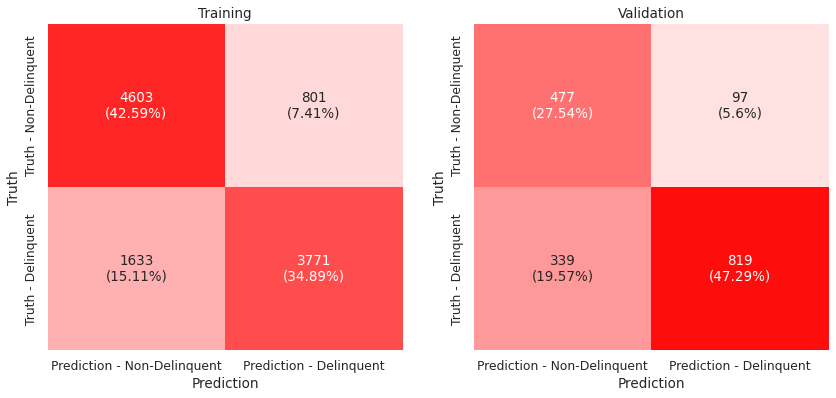

In [55]:
# Confusion matrices for training and validation sets
y_recon = reg_lgc_over.predict(X_train_over) # Reconstructing the training data
y_pred = reg_lgc_over.predict(X_valid)  # Forecasting the validation data

# Plotting the confusion matrices
plt.figure(figsize = (14, 6));
# Training data
plt.subplot(121);
confusion_matrix_evince(y_train_over, y_recon);
plt.title('Training');
# Validation data
plt.subplot(122);
confusion_matrix_evince(y_valid, y_pred);
plt.title('Validation');

In [56]:
# Cross-validation on training set to find out the range of performance 

# Dividing training set into 10 random folds
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
# Evaluating the recall score on all folds
cv_recalls = cross_val_score(reg_lgc_over, X_train_over, y_train_over, cv = kfold, scoring = 'recall')

print('The average recall score of the oversampled model is {} and, with 95% confidence, the recall score falls between {} and {}.'
      .format(round(cv_recalls.mean(), 3), round(cv_recalls.mean() - 2*cv_recalls.std(), 3),
              round(cv_recalls.mean() + 2*cv_recalls.std(), 3)))   

The average recall score of the oversampled model is 0.698 and, with 95% confidence, the recall score falls between 0.66 and 0.735.


#### Observations:

Although some of the hyperparameters of the regularized model are different from those of the original oversampled model, regularization has caused no change in the performance metrics.

### Regularization of the Undersampled Model

Here, we carry out a grid search on C = 1/$\lambda$, where $\lambda$ is the regularization hyperparameter, as well as the type of regularization (L1 or L2), to find the best undersampled model that maximizes recall.

In [57]:
# Defining the base estimator
base_estimator = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 1)

# Setting the range of hyperparameters
hyperparams = {'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'penalty': ['l1', 'l2']}

# Setting the accuracy criterion
acc_criterion = make_scorer(recall_score)

# Coducting a grid search on hyperparameters
all_reg_models = GridSearchCV(base_estimator, param_grid = hyperparams, scoring = acc_criterion, cv = 5)
all_reg_models = all_reg_models.fit(X_train_under, y_train_under)  

# Finding the best regularized model
reg_lgc_under = all_reg_models.best_estimator_
reg_lgc_under = reg_lgc_under.fit(X_train_under, y_train_under)  
reg_lgc_under

LogisticRegression(C=0.8, max_iter=1000, random_state=1, solver='liblinear')

In [58]:
# Demonstrating the performance of model on training and validation sets
reg_lgc_under_perform = model_eval(reg_lgc_under, X_train_under, X_valid, y_train_under, y_valid)
reg_lgc_under_perform

,Accuracy,Recall,Precision,F1,Specificity
Train,0.790,0.769,0.803,0.786,0.811
Validation,0.786,0.784,0.882,0.830,0.789


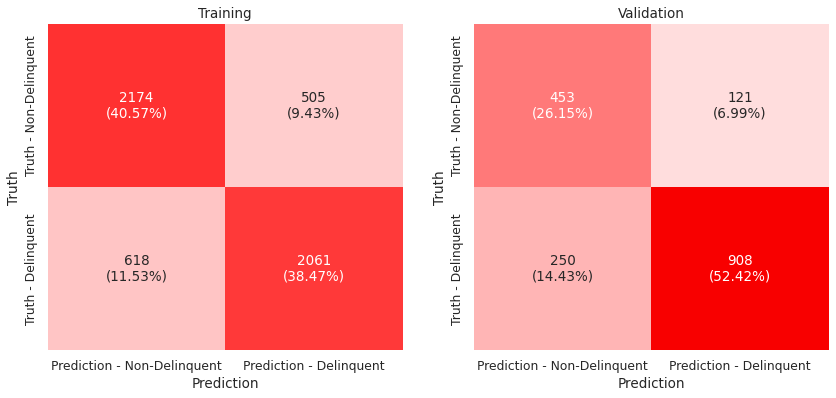

In [59]:
# Confusion matrices for training and validation sets
y_recon = reg_lgc_under.predict(X_train_under) # Reconstructing the training data
y_pred = reg_lgc_under.predict(X_valid)  # Forecasting the validation data

# Plotting the confusion matrices
plt.figure(figsize = (14, 6));
# Training data
plt.subplot(121);
confusion_matrix_evince(y_train_under, y_recon);
plt.title('Training');
# Validation data
plt.subplot(122);
confusion_matrix_evince(y_valid, y_pred);
plt.title('Validation');

In [60]:
# Cross-validation on training set to find out the range of performance 

# Dividing training set into 10 random folds
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
# Evaluating the recall score on all folds
cv_recalls = cross_val_score(reg_lgc_under, X_train_under, y_train_under, cv = kfold, scoring = 'recall')

print('The average recall score of the oversampled model is {} and, with 95% confidence, the recall score falls between {} and {}.'
      .format(round(cv_recalls.mean(), 3), round(cv_recalls.mean() - 2*cv_recalls.std(), 3),
              round(cv_recalls.mean() + 2*cv_recalls.std(), 3)))   

The average recall score of the oversampled model is 0.764 and, with 95% confidence, the recall score falls between 0.71 and 0.818.


#### Observations:

However, C in the regularized model has changed from 1 to 0.8, with respect to the original undersampled model, there is absolutely no difference between the performance metrics of the two models.

## Comparison of All Models

In [61]:
# Calculating the performances of each model on the training and testing sets
model0 = model_eval(lgc0, X_train, X_test, y_train, y_test, valid = False)  # baseline model
model_over = model_eval(lgc_over, X_train_over, X_test, y_train_over, y_test, valid = False)  # oversampled model
model_under = model_eval(lgc_under, X_train_under, X_test, y_train_under, y_test, valid = False)  # undersampled model
model_reg_over = model_eval(reg_lgc_over, X_train_over, X_test, y_train_over, y_test, valid = False)  # regularized oversampled model
model_reg_under = model_eval(lgc_under, X_train_under, X_test, y_train_under, y_test, valid = False)  # regularized underampled model

# Building a single dataframe out of all performance dataframes and separating its rows that correspond to test set 
test_perform = pd.concat([model0, model_over, model_under, model_reg_over, model_reg_under])[1::2] 
test_perform.index = ['Baseline Model', 'Oversampled Model', 'Undersampled Model', 'Regularized Oversampled Model',
                      'Regularized Undersampled Model']
test_perform

,Accuracy,Recall,Precision,F1,Specificity
Baseline Model,0.783,0.874,0.815,0.843,0.599
Oversampled Model,0.757,0.724,0.893,0.799,0.824
Undersampled Model,0.782,0.777,0.882,0.827,0.791
Regularized Oversampled Model,0.757,0.724,0.893,0.799,0.824
Regularized Undersampled Model,0.782,0.777,0.882,0.827,0.791


## Interpretation of the Best Model

Since a logistic regression model is linear with respect the log(odds) function, to find the odds, the odds and the percentage of change in them are respectively given by **odds =  exp(b)** and **odds = (exp(b) - 1) * 100**, where b is the coefficient of the predictor under study, and the rest of predictors are assumed to remain constant.

In [63]:
# Finding the coefficients of the best model (baseline model)
lgc0_coeffs = lgc0.coef_.flatten()

# Making a dataframe of odds and odds change
coeff_interpret = pd.DataFrame(index = ['Odds', 'Odds Change (%)'], columns = X.columns.tolist())
coeff_interpret.iloc[0, :] = np.exp(lgc0_coeffs) 
coeff_interpret.iloc[1, :] = (np.exp(lgc0_coeffs) - 1)*100 
coeff_interpret

,term_60 months,gender_Male,purpose_House,purpose_Medical,purpose_Other,purpose_Personal,purpose_Wedding,home_ownership_Own,home_ownership_Rent,age_>25,FICO_>500
Odds,0.126,2.326,1.098,1.404,0.997,1.152,1.072,1.191,0.879,1.789,0.124
Odds Change (%),-87.406,132.581,9.768,40.417,-0.291,15.186,7.229,19.127,-12.117,78.886,-87.587


#### Observations:

*   As anticipated, loan term and FICO score have significant impacts on the predictions of the model, while the influences of other independent variables are comparatively small.
*   In fact, the variation of the FICO score range from under 500 to over 500, or the increase of loan term from 36 months to 60 months, each individiually, reduces the chance of delinquency by more than 85%.   